In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

### Preparing the data:

In [74]:
from sklearn.model_selection import train_test_split

In [157]:
X, y = mnist['data'], mnist['target'].astype(np.uint8)

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [159]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25)

In [160]:
X_train, X_test, X_valid = X_train/255, X_test/255, X_valid/255

### Expanding the dataset:

In [97]:
side, up, repository = np.zeros((28,1)), np.zeros((28)), []

for i in range(len(X_train)):
    repository.append(np.concatenate((up, X_train.iloc[i][:-28])))    
    repository.append(np.concatenate((X_train.iloc[i][28:], up)))
    temp = np.array(X_train.iloc[i]).reshape(28,28)[:, 0:-1]
    repository.append(np.c_[side, temp].reshape(784))
    temp = np.array(X_train.iloc[i]).reshape(28,28)[:, 1:]
    repository.append(np.c_[temp, side].reshape(784))
    
labels_ext = []
for i in range(len(X_train)):
    labels_ext.append(y_train.iloc[i])
    labels_ext.append(y_train.iloc[i])
    labels_ext.append(y_train.iloc[i])
    labels_ext.append(y_train.iloc[i])
labels_ext = pd.Series(labels_ext)

y_train = labels_ext.append(y_train.copy())
repository = pd.DataFrame(np.array(repository), columns=X_train.columns)
X_train = repository.append(X_train.copy(), ignore_index=True)
X_train.shape, y_train.shape

((210000, 784), (210000,))

# Making the model:

In [ ]:
model = keras.Sequential()

In [ ]:
model.add(keras.layers.Dense(300, input_shape=[784]))
model.add(keras.layers.Dense(400, activation='relu'))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(400, activation='relu'))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
keras.utils.plot_model(model, show_shapes=1)

In [ ]:
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 100, callbacks=[keras.callbacks.EarlyStopping(patience=10), keras.callbacks.ModelCheckpoint('my_keras_model.h5', save_best_only=1)])
model = keras.models.load_model('my_keras_model.h5')

In [ ]:
history = pd.DataFrame(history.history)

In [ ]:
history.plot()
plt.grid(1)

In [ ]:
model.evaluate(X_test, y_test)[1]

### Model 2:

In [98]:
def modMaker(units=100, layers=3, learning_rate=0.01):
    model2 = keras.Sequential()
    model2.add(keras.layers.Dense(784, input_shape=[784]))
    for _ in range(layers):
        model2.add(keras.layers.Dense(units, activation='relu'))
    model2.add(keras.layers.Dense(10, activation='softmax'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model2

I want to iterate over different learning rates, differing by powers of 10, and then save the best model produced. I could implement the ModelCheckpoint callback and use a different model name for each model, and also record which k corresponds to the best score. Then use the best version of that model.

In [99]:
eval_scores = []
for k in range(5, 9):
    earlyStop = keras.callbacks.EarlyStopping(patience=10)
    save = keras.callbacks.ModelCheckpoint('model_'+str(k)+'.h5', save_best_only=1)
    model2 = modMaker(200, k, 2/(10**2))
    model2.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, callbacks=[earlyStop, save])
    modelTest = keras.models.load_model('model_'+str(k)+'.h5')
    eval_scores.append((modelTest.evaluate(X_test, y_test)[1], k))

Epoch 1/100
6563/6563 [==============================] - 32s 5ms/step - loss: 0.5098 - accuracy: 0.8395 - val_loss: 0.1029 - val_accuracy: 0.9683
Epoch 2/100
6563/6563 [==============================] - 33s 5ms/step - loss: 0.0817 - accuracy: 0.9736 - val_loss: 0.0670 - val_accuracy: 0.9799
Epoch 3/100
6563/6563 [==============================] - 35s 5ms/step - loss: 0.0509 - accuracy: 0.9839 - val_loss: 0.0576 - val_accuracy: 0.9808
Epoch 4/100
6563/6563 [==============================] - 33s 5ms/step - loss: 0.0357 - accuracy: 0.9883 - val_loss: 0.0572 - val_accuracy: 0.9822
Epoch 5/100
6563/6563 [==============================] - 31s 5ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0700 - val_accuracy: 0.9788
Epoch 6/100
6563/6563 [==============================] - 33s 5ms/step - loss: 0.0197 - accuracy: 0.9935 - val_loss: 0.0828 - val_accuracy: 0.9783
Epoch 7/100
6563/6563 [==============================] - 34s 5ms/step - loss: 0.0155 - accuracy: 0.9949 - val_loss: 0.0575 -

KeyboardInterrupt: 

The scores below were obtained by extending the training set

In [100]:
eval_scores

[(0.981071412563324, 5)]

In [101]:
model2.evaluate(X_test, y_test)

438/438 [==============================] - 1s 2ms/step - loss: 0.0676 - accuracy: 0.9811


[0.0676131471991539, 0.9811428785324097]

# Making a custom callback to plot learning rate against loss

In [161]:
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []    
    def on_batch_end(self, batch, logs):
        self.rates.append(keras.backend.get_value(self.model.optimizer.lr))
        self.losses.append(logs['loss'])
        keras.backend.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [197]:
model3 = keras.models.Sequential(
    [keras.layers.Dense(784, input_shape=[784]),
     keras.layers.Dense(300, activation='relu'),
     keras.layers.Dense(100, activation='relu'),
     keras.layers.Dense(10, activation='softmax')])

In [198]:
model3.compile(optimizer=keras.optimizers.SGD(lr=3e-1), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [164]:
exp_lr = ExponentialLearningRate(factor=1.0005)

In [165]:
model3.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid), callbacks=[exp_lr])

1313/1313 [==============================] - 8s 6ms/step - loss: 223505066638.7933 - accuracy: 0.8049 - val_loss: 2.3044 - val_accuracy: 0.1154


(0.30000001192092896, 0.5779981017112732, 0.0, 2.3113279342651367)

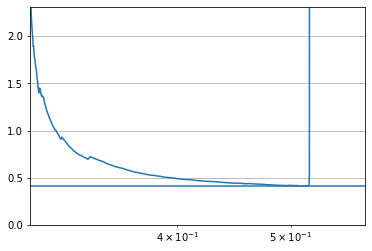

In [187]:
plt.plot(exp_lr.rates, exp_lr.losses)
plt.gca().set_xscale('log')
plt.grid()
plt.hlines(min(exp_lr.losses), min(exp_lr.rates), max(exp_lr.rates))
plt.axis([min(exp_lr.rates), max(exp_lr.rates), 0, exp_lr.losses[0]])

In [ ]:
model3.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.5187 - accuracy: 0.8356 - val_loss: 0.2242 - val_accuracy: 0.9332
Epoch 2/100
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1447 - accuracy: 0.9559 - val_loss: 0.2380 - val_accuracy: 0.9418
Epoch 3/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.1152 - accuracy: 0.9643 - val_loss: 0.1243 - val_accuracy: 0.9660
Epoch 4/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0909 - accuracy: 0.9721 - val_loss: 0.1051 - val_accuracy: 0.9710
Epoch 5/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0836 - accuracy: 0.9748 - val_loss: 0.1225 - val_accuracy: 0.9666
Epoch 6/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0721 - accuracy: 0.9764 - val_loss: 0.1818 - val_accuracy: 0.9484
Epoch 7/100
1313/1313 [==============================] - 7s 5ms/step - loss: 0.0836 - accuracy: 0.9743 - val_loss: 0.1181 - val_ac